In [33]:
import os
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


In [2]:
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [32]:
def extract_roles(folder):
    files = os.listdir(folder)

    roles = {
        "actor": [],
        "victim": [],
        "neither": []
    }

    for file in files:
        if file.endswith(".json"):
            data = load_json(os.path.join(folder, file))
            if data['analysis'] and data['analysis']['Q3']:
                for item in data['analysis']['Q3']:
                    if 'actor' in item['category'].lower():
                        roles['actor'].append(item['name'])
                    elif 'victim' in item['category'].lower():
                        roles['victim'].append(item['name'])
                    else:
                        roles['neither'].append(item['name'])
    return roles
    
folder = "/mnt/hdd/RA/Codes/stable/news_anlyzed_gpt4o_fixed"
roles = extract_roles(folder)

In [28]:
def cluster_similar_phrases(phrases: list, n_components: int = 5, distance_threshold: float = 0.7):
    """
    Cluster similar phrases into unique buckets using TF-IDF, SVD, and Agglomerative Clustering.

    Parameters:
    - phrases: List of phrases to cluster.
    - n_components: Number of components for Truncated SVD.
    - distance_threshold: Distance threshold for Agglomerative Clustering.

    Returns:
    - Dictionary of buckets with cluster labels as keys and lists of phrases as values.
    """
    # Preprocess the phrases
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(phrases)

    # Convert to vectors and apply dimensionality reduction
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)

    # Normalize the vectors
    norms = np.linalg.norm(reduced_matrix, axis=1, keepdims=True)
    normalized_matrix = reduced_matrix / norms

    # Handle NaN values by imputing with zeros
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    normalized_matrix = imputer.fit_transform(normalized_matrix)

    # Apply clustering with adjusted distance threshold
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
    labels = clustering.fit_predict(normalized_matrix)

    # Assign phrases to buckets
    buckets = {}
    for label, phrase in zip(labels, phrases):
        buckets.setdefault(label, []).append(phrase)
    
    return buckets


In [34]:
def calculate_frequency(tags):
    tag_freq = {}
    for tag in tags:
        tag_freq[tag] = tag_freq.get(tag, 0) + 1
    return tag_freq

def generate_tag_cloud(tags):
    tag_freq = calculate_frequency(tags)
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(tag_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Word cloud for actor


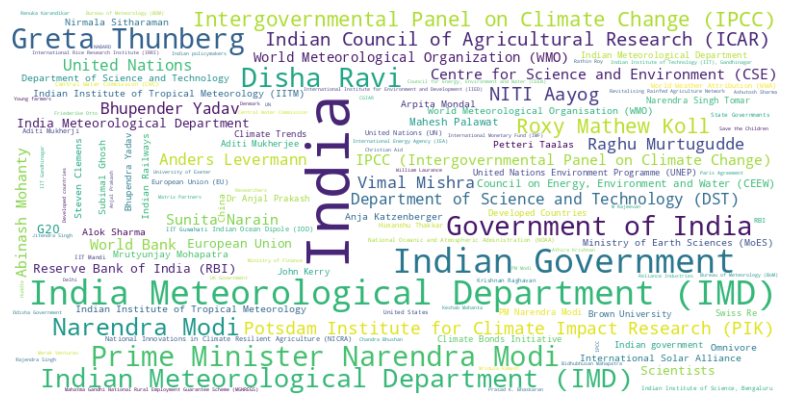

Word cloud for victim


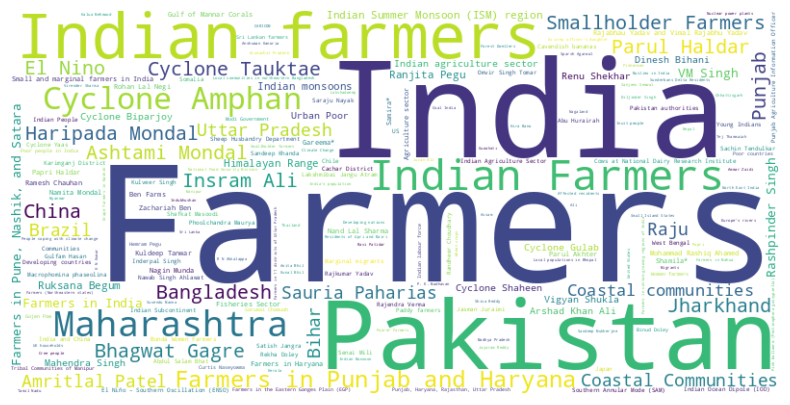

Word cloud for neither


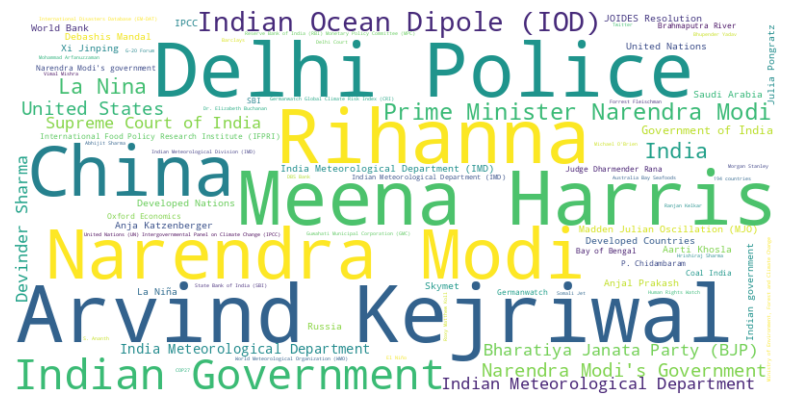

In [35]:
# plot word cloud for each role
for role, tags in roles.items():
    print(f"Word cloud for {role}")
    generate_tag_cloud(tags)
    